In [1]:
!pip install socceraction==0.2.0


[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep.formula import value
from tqdm.notebook import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.features as fs
import socceraction.xthreat as xthreat

In [4]:
import os
import tqdm
import pandas as pd
import numpy as np

In [5]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [6]:
data_files = {
    'events': 'https://ndownloader.figshare.com/files/14464685',  # ZIP file containing one JSON file for each competition
    'matches': 'https://ndownloader.figshare.com/files/14464622',  # ZIP file containing one JSON file for each competition
    'players': 'https://ndownloader.figshare.com/files/15073721',  # JSON file
    'teams': 'https://ndownloader.figshare.com/files/15073697'  # JSON file
}

In [8]:
from tqdm.notebook import tqdm

In [9]:
for url in tqdm(data_files.values()):
    url_s3 = urlopen(url).geturl()
    path = Path(urlparse(url_s3).path)
    file_name = path.name
    file_local, _ = urlretrieve(url_s3, file_name)
    if is_zipfile(file_local):
        with ZipFile(file_local) as zip_file:
            zip_file.extractall()

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
import json

In [11]:
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [12]:
json_teams = read_json_file('teams.json')
df_teams = pd.read_json(json_teams)

In [13]:
df_teams.to_hdf('wyscout.h5', key='teams', mode='w')

In [14]:
json_players = read_json_file('players.json')
df_players = pd.read_json(json_players)

In [15]:
df_players.to_hdf('wyscout.h5', key='players', mode='a')

In [16]:
competitions = [
#     'England',
#     'France',
#     'Germany',
#     'Italy',
    'Spain',
    'European Championship',
    'World Cup'
]

In [17]:
dfs_matches = []
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)
df_matches = pd.concat(dfs_matches)

In [18]:
df_matches.to_hdf('wyscout.h5', key='matches', mode='a')

In [19]:
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(file_events)
    df_events = pd.read_json(json_events)
    df_events_matches = df_events.groupby('matchId', as_index=False)
    for match_id, df_events_match in df_events_matches:
        df_events_match.to_hdf('wyscout.h5', key=f'events/match_{match_id}', mode='a')

In [20]:
convert_to_spadl('wyscout.h5', 'spadl.h5')

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████████████████████████████████████████████████████████████████████████| 495/495 [01:20<00:00,  6.11game/s]


...Converting events to actions


100%|██████████████████████████████████████████████████████████████████████████████| 495/495 [08:38<00:00,  1.05s/game]


In [21]:
df_games = pd.read_hdf('spadl.h5', key='games')
df_actiontypes = pd.read_hdf('spadl.h5', key='actiontypes')
df_bodyparts = pd.read_hdf('spadl.h5', key='bodyparts')
df_results = pd.read_hdf('spadl.h5', key='results')

In [22]:
datafolder = "../Thesis-Notebooks"
spadl_h5 = os.path.join(datafolder, "spadl.h5")
xT_h5 = os.path.join(datafolder, "xT.h5")

In [23]:
games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(games))


nb of games: 495


In [25]:
import tqdm

In [43]:
A = []

with pd.HDFStore(spadl_h5) as spadlstore:
    for game in tqdm.tqdm(list(games.itertuples())):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        actions = spadl.add_names(actions)
        actions = spadl.play_left_to_right(actions, game.home_team_id)
        A.append(actions) 


100%|████████████████████████████████████████████████████████████████████████████████| 495/495 [00:16<00:00, 30.08it/s]


In [48]:
A = pd.concat(A)

In [49]:
url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xTModel = xthreat.load_model(url_grid)

In [50]:
xTModel = xthreat.ExpectedThreat(l=16, w=12)


In [51]:
xTModel.fit(A);

# iterations:  30


In [52]:
mov_actions = xthreat.get_successful_move_actions(A)
mov_actions["xT_value"] = xTModel.rate(mov_actions)
mov_actions[["type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]][:10]

,type_name,start_x,start_y,end_x,end_y,xT_value
0,pass,51.45,33.32,38.85,50.32,-0.002429
1,pass,38.85,50.32,74.55,5.44,0.007924
2,pass,74.55,5.44,84.00,0.00,0.003499
5,pass,71.40,1.36,75.60,10.88,0.004659
6,pass,75.60,10.88,81.90,4.08,0.001894
7,pass,33.60,65.96,36.75,60.52,0.001034
8,pass,36.75,60.52,33.60,59.84,0.000000
11,pass,35.70,50.32,38.85,65.96,-0.002055
12,dribble,38.85,65.96,39.90,62.56,0.000987
13,pass,39.90,62.56,33.60,65.96,-0.000987


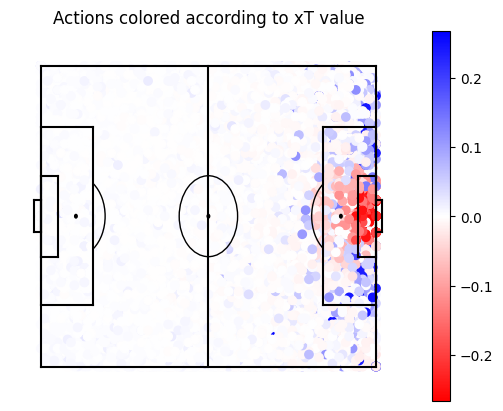

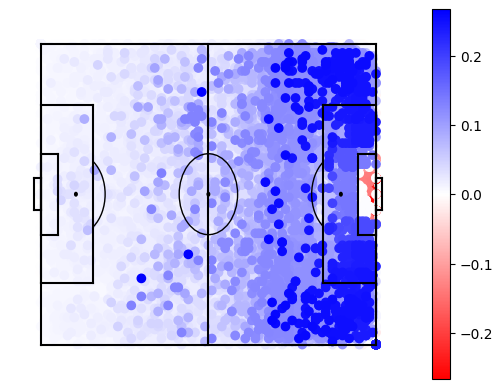

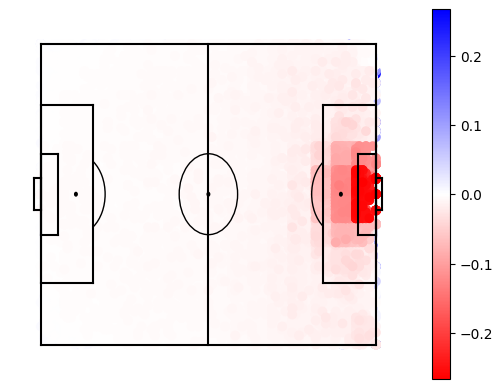

In [54]:
import matplotlib.pyplot as plt
import matplotsoccer as mps

## Visualize xT predictions 
a = mov_actions

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.title("Actions colored according to xT value")
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with low xT Values on top
a = a.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with high xT Values on top
a = a.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()